# Bike Sharing Problem Revisited

In this exercise, you will apply your *Auto-ML* once again to the [UCI Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset). But this time, you will remove data values of which cannot be guaranteed to be present at inference time (temp, humidity, etc.).

*Note: Click the link to know more about the dataset*

![Bike *source: https://www.cntraveler.com/story/the-worlds-first-bicycle-mayor-guides-us-through-amsterdam*](images/bike-cover.jpg)

<div class="alert alert-info">

**Instructions**
    
1. **Read the hourly bike sharing data** from `data/bike_sharing_hourly.csv`.
2. **Remove columns** whose values cannot be guaranteed at inference time (`weathersit`, `temp`, `atemp`, `hum`, and `windspeed`).
3. **Run your AutoML** on the preprocessed dataset then **comment on the results**.

    
*Note: Attach any additional **module** or **package** that you will use alongside this exercise*
</div>

<div class="alert alert-success">

**Rubric**
    
1. **Data Preprocessing** - unnecessary columns are removed, categorical columns are one-hot encoded.
2. **Data Segregation** - set aside the last 21 days as your test dataset, and the remaining as your train/validation dataset.
3. **Experimentation Settings**
    1. At least `10` number of trials or at least `3`-fold cross validation
    2. Test size of `20%`
    3. Required models: Gradient Boosting Regressor, Random Forest Regressor, and Decision Tree
    4. Hyperparameter range setting: max depth of `2` to `10`, number of estimators of at least `50`.
4. **Results**
    1. Summary table - train accuracy, val/test accuracy, best parameter, train time, top predictor.
    2. Plots - train and val/test accuracy, feature importance plot
5. **Comments**
    1. What is the model that you will use? At what hyperparameter? Why?
    2. Discuss which features were deemed important by the model.
    3. Give any additional insight on the model performances or feature importances.
</div>

## Data Preprocessing

In [1]:
# PLACE YOUR CODE HERE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import time

# Check the data
rides = pd.read_csv('bike_sharing_hour.csv')
rides = rides.drop(['weathersit', 'temp', 'atemp', 'hum','windspeed'],
                   axis=1)
rides.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,0,1,1


In [2]:
# Use one-hot encode to replace select categrical variables like season, weather, month using get_dummies()
dummy_fields = ['season', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 
                  'weekday', 'mnth', 'workingday', 'hr']
rides = rides.drop(fields_to_drop, axis=1)
rides.head(5)

,yr,holiday,casual,registered,cnt,season_1,season_2,season_3,season_4,mnth_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,3,13,16,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,8,32,40,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,5,27,32,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,3,10,13,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## Data Segregation

In [3]:
# Use the last 21 days as test set
days = 21
test_data = rides[-days*24:]
# Save the remaining data into data
full_train_data = rides[:-21*24] 
full_train_data

,yr,holiday,casual,registered,cnt,season_1,season_2,season_3,season_4,mnth_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,3,13,16,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,8,32,40,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,5,27,32,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,3,10,13,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16870,1,0,38,578,616,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
16871,1,0,20,544,564,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
16872,1,0,18,409,427,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
16873,1,0,13,287,300,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## Model Experimentation

In [4]:
# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']

# Use only 'cnt' as target field
features, targets = full_train_data.drop(target_fields, axis=1), full_train_data['cnt'] # Training Set
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data['cnt'] # Test Set

In [5]:
# Set parameters

# Set number of trials
num_trials = 10

# Assign X and Y
X = features
y = targets

# Assign test
X_test = test_features
y_test = test_targets

# Set feature names
feature_names = np.array(features.columns)

In [6]:
# GBM
def train_GBM(X, y):
    start_time = time.time()
    max_depth_range = list(range(2, 11))
    score_train = []
    score_val = []
    mean_abs_coefs = []

    for seed in range(num_trials):
        training_accuracy = []  
        val_accuracy = []
        model_coefs = []
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)

        for depth in max_depth_range:       
            GBM = GradientBoostingRegressor(n_estimators=50, max_features='log2', max_depth=depth).fit(X_train, y_train)
            training_accuracy.append(GBM.score(X_train, y_train))
            val_accuracy.append(GBM.score(X_val, y_val))
            model_coefs.append(np.abs(GBM.feature_importances_))

        score_train.append(training_accuracy)
        score_val.append(val_accuracy)

    score_val_means = np.mean(score_val, axis=0)
    best_index = np.argmax(score_val_means)

    mean_abs_coefs = np.mean(model_coefs, axis=0)
    best_mean_coefs = mean_abs_coefs[best_index]
    best_predictor = feature_names[np.argmax(mean_abs_coefs)]

    model_name = "Gradient Boosting Method"
    best_val = np.amax(score_val_means)
    hyperparam = "Max depth"
    best_param = max_depth_range[best_index]

    coefs_count = len(mean_abs_coefs)
    fig, ax = plt.subplots(figsize=(4,7))
    ax.barh(np.arange(coefs_count), sorted(mean_abs_coefs))
    ax.set_xlabel('Feature importance')
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(feature_names[np.argsort(mean_abs_coefs)])
    fig.suptitle(model_name)
    fig.tight_layout()

    model_test = GradientBoostingRegressor(n_estimators=50, max_features='log2',
                                           max_depth=best_param).fit(X, y)
    score_test = model_test.score(X_test, y_test)
    
    run_time = (time.time() - start_time)
    return [model_name, best_val, score_test, hyperparam, best_param,
            best_predictor, run_time], score_train, score_val

# RANDOM FOREST
def train_RF(X, y):
    start_time = time.time()
    #max_features_range = [0.2, 0.4, 0.6, 0.8]
    max_depth_range = list(range(2, 11))
    score_train = []
    score_val = []
    mean_abs_coefs = []

    for seed in range(num_trials):
        training_accuracy = []  
        val_accuracy = []
        model_coefs = []
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=seed)

        for depth in max_depth_range:       
            RF = RandomForestRegressor(n_estimators=50, max_features='log2', 
                                       max_depth=depth).fit(X_train, y_train)
            training_accuracy.append(RF.score(X_train, y_train))
            val_accuracy.append(RF.score(X_val, y_val))
            model_coefs.append(np.abs(RF.feature_importances_))

        score_train.append(training_accuracy)
        score_val.append(val_accuracy)

    score_val_means = np.mean(score_val, axis=0)
    best_index = np.argmax(score_val_means)

    mean_abs_coefs = np.mean(model_coefs, axis=0)
    best_mean_coefs = mean_abs_coefs[best_index]
    best_predictor = feature_names[np.argmax(mean_abs_coefs)]

    model_name = "Random Forest"
    best_val = np.amax(score_val_means)
    hyperparam = "Max depth"
    best_param = max_depth_range[best_index]

    coefs_count = len(mean_abs_coefs)
    fig, ax = plt.subplots(figsize=(4,7))
    ax.barh(np.arange(coefs_count), sorted(mean_abs_coefs))
    ax.set_xlabel('Feature importance')
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(feature_names[np.argsort(mean_abs_coefs)])
    fig.suptitle(model_name)
    fig.tight_layout()

    model_test = RandomForestRegressor(max_depth=best_param, n_estimators=50, max_features='log2').fit(X, y)
    score_test = model_test.score(X_test, y_test)

    run_time = (time.time() - start_time)
    return [model_name, best_val, score_test, hyperparam, best_param,
            best_predictor, run_time], score_train, score_val



# DECISION TREE
def train_DT(X, y):
    start_time = time.time()
    max_depth_range = list(range(2, 11))
    score_train = []
    score_val = []
    mean_abs_coefs = []

    for seed in range(num_trials):
        training_accuracy = []  
        val_accuracy = []
        model_coefs = []
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, 
                                                          random_state=seed)

        for depth in max_depth_range:       
            DT = DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train)
            training_accuracy.append(DT.score(X_train, y_train))
            val_accuracy.append(DT.score(X_val, y_val))
            model_coefs.append(np.abs(DT.feature_importances_))

        score_train.append(training_accuracy)
        score_val.append(val_accuracy)

    score_val_means = np.mean(score_val, axis=0)
    best_index = np.argmax(score_val_means)

    mean_abs_coefs = np.mean(model_coefs, axis=0)
    best_mean_coefs = mean_abs_coefs[best_index]
    best_predictor = feature_names[np.argmax(mean_abs_coefs)]

    model_name = "Decision Tree"
    best_val = np.amax(score_val_means)
    hyperparam = "Max depth"
    best_param = max_depth_range[best_index]

    coefs_count = len(mean_abs_coefs)
    fig, ax = plt.subplots(figsize=(4,7))
    ax.barh(np.arange(coefs_count), sorted(mean_abs_coefs))
    ax.set_xlabel('Feature importance')
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(feature_names[np.argsort(mean_abs_coefs)])
    fig.suptitle(model_name)
    fig.tight_layout()

    model_test = DecisionTreeRegressor(max_depth=best_param).fit(X, y)
    score_test = model_test.score(X_test, y_test)

    run_time = (time.time() - start_time)
    return [model_name, best_val, score_test, hyperparam, best_param,
            best_predictor, run_time], score_train, score_val

## Model Results

In [7]:
cols = ['Regression Method', 'Best validation accuracy',
        'Test accuracy', 'Hyperparameter', 'Best parameter value', 'Top predictor variable', 'Run time']
df_results = pd.DataFrame(columns=cols)

df_results.loc[0], dt_train_acc_list, dt_val_acc_list = train_DT(X, y)
df_results.loc[1], rf_train_acc_list, rf_val_acc_list = train_RF(X, y)
df_results.loc[2], gbm_train_acc_list, gbm_val_acc_list = train_GBM(X, y)
display(df_results)

,Regression Method,Best validation accuracy,Test accuracy,Hyperparameter,Best parameter value,Top predictor variable,Run time
0,Decision Tree,0.622999,0.264047,Max depth,10,hr_17,3.475666
1,Random Forest,0.580290,0.400924,Max depth,10,hr_17,17.763437
2,Gradient Boosting Method,0.805071,0.511782,Max depth,10,hr_17,18.780753


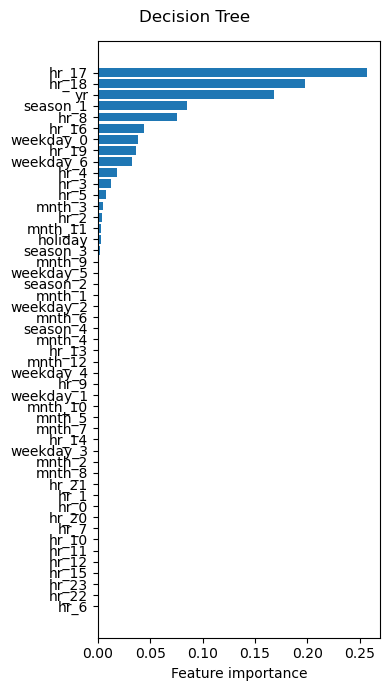

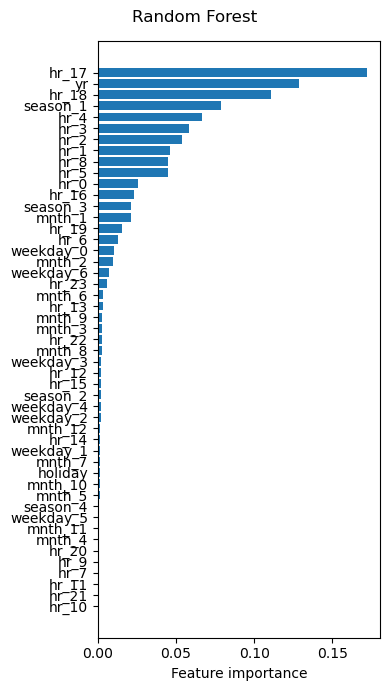

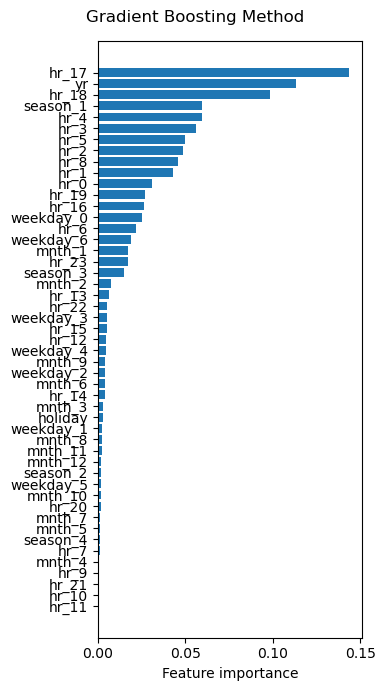

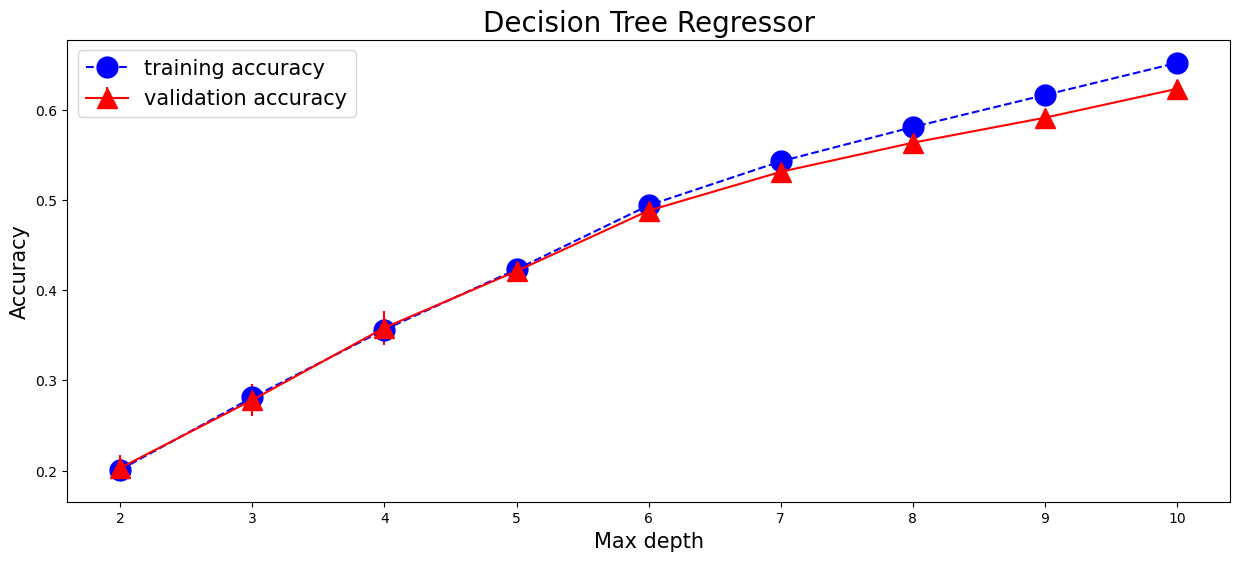

In [8]:
# Decision Tree
import pylab as plot

dt_train_acc_list_mean = np.mean(dt_train_acc_list, axis=0)
dt_train_acc_list_std = np.std(dt_train_acc_list, axis=0)
dt_val_acc_list_mean = np.mean(dt_val_acc_list, axis=0)
dt_val_acc_list_std = np.std(dt_val_acc_list, axis=0)
max_depth_range = list(range(2, 11))

fig = plt.figure(figsize=(15, 6))

params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(max_depth_range, dt_train_acc_list_mean,
             yerr=dt_train_acc_list_std, label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(max_depth_range, dt_val_acc_list_mean,
             yerr=dt_val_acc_list_std, label="validation accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Max depth",fontsize=15)
plt.legend()
plt.title('Decision Tree Regressor', fontsize=20)
plt.show()

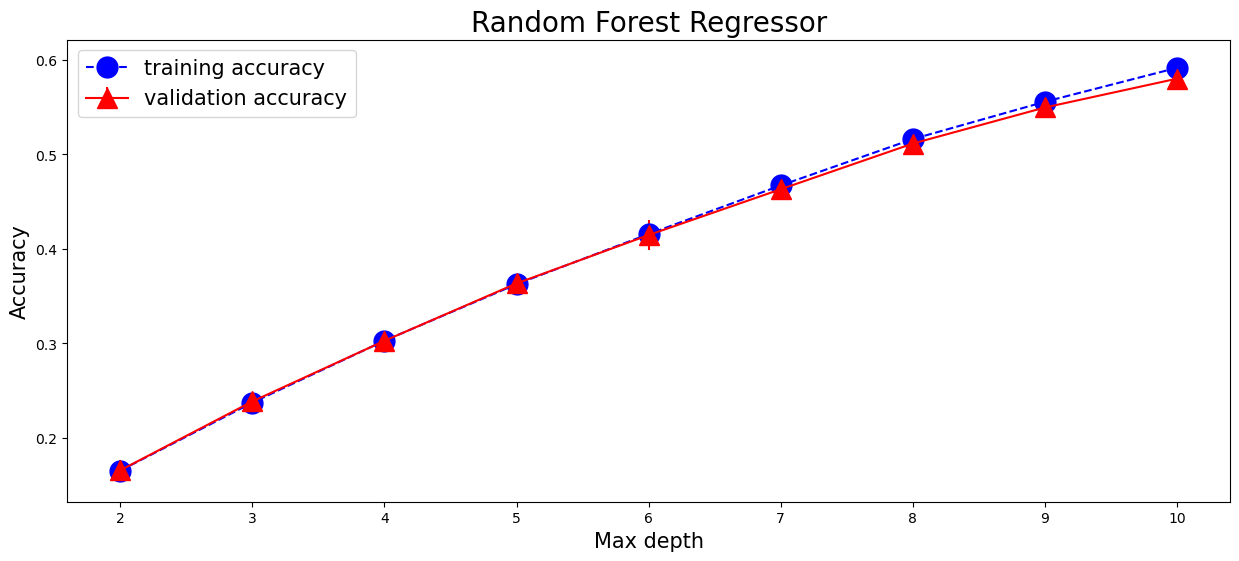

In [9]:
# Random Forest
rf_train_acc_list_mean = np.mean(rf_train_acc_list, axis=0)
rf_train_acc_list_std = np.std(rf_train_acc_list, axis=0)
rf_val_acc_list_mean = np.mean(rf_val_acc_list, axis=0)
rf_val_acc_list_std = np.std(rf_val_acc_list, axis=0)
max_depth_range = list(range(2, 11))

fig = plt.figure(figsize=(15, 6))

params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(max_depth_range, rf_train_acc_list_mean,
             yerr=rf_train_acc_list_std, label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(max_depth_range, rf_val_acc_list_mean,
             yerr=rf_val_acc_list_std, label="validation accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Max depth",fontsize=15)
plt.legend()
plt.title('Random Forest Regressor', fontsize=20)
plt.show()

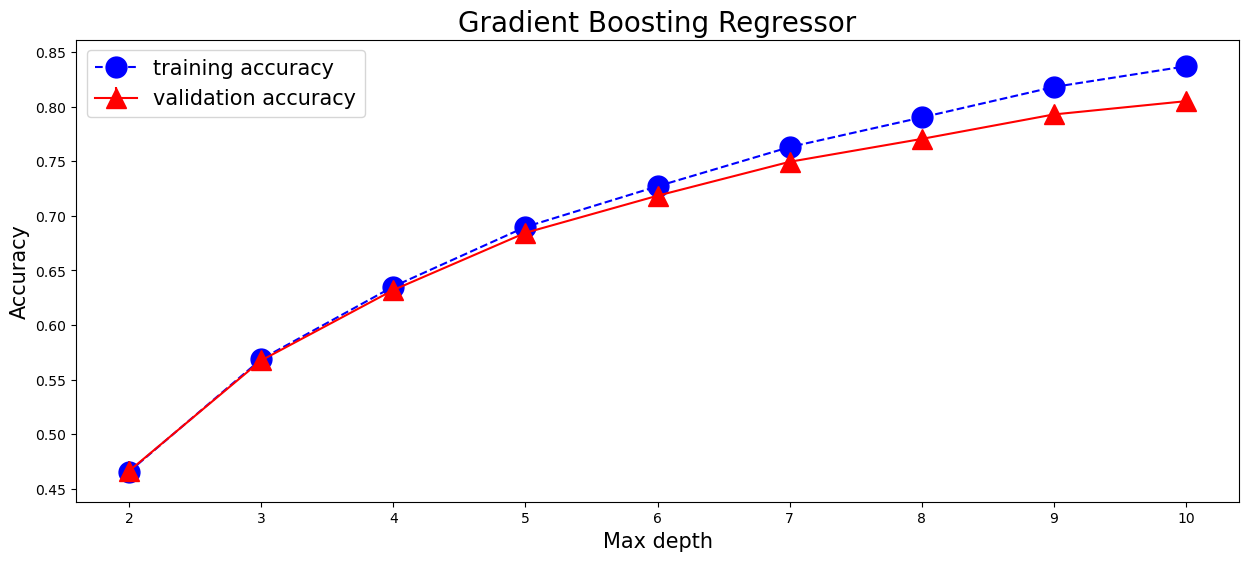

In [10]:
# Gradient Boosting
gbm_train_acc_list_mean = np.mean(gbm_train_acc_list, axis=0)
gbm_train_acc_list_std = np.std(gbm_train_acc_list, axis=0)
gbm_val_acc_list_mean = np.mean(gbm_val_acc_list, axis=0)
gbm_val_acc_list_std = np.std(gbm_val_acc_list, axis=0)
max_depth_range = list(range(2, 11))

fig = plt.figure(figsize=(15, 6))

params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(max_depth_range, gbm_train_acc_list_mean,
             yerr=gbm_train_acc_list_std, label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(max_depth_range, gbm_val_acc_list_mean,
             yerr=gbm_val_acc_list_std, label="validation accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Max depth",fontsize=15)
plt.legend()
plt.title('Gradient Boosting Regressor', fontsize=20)
plt.show()

## Discussion

1) What is the model that you will use? At what hyperparameter? Why?
Based on the testing accuracy in the model results above, we shall use the `Random Forest` model at `max_depth=10`. This is the model and hyperparameter settings that gave the highest test accuracy at 0.5279. In terms of run time, the random forest model took the longest time to run. 

2) Discuss which features were deemed important by the model.
Based on the three models evaluated, the predictor variable which was deemed most important is `hr_17` or 05:00 PM. Other predictors that appear at the top of the feature important plots are `hr_18` or 06:00 PM, yr (“year”), and `season_1` (“winter”). 

3) Give any additional insight on the model performances or feature importances. 

On **Decision Tree**: we did not choose this model because it showed the poorest test accuracy among the three models, despite performing the fastest among them. There is a huge difference between the validation accuracy and test accuracy. With this, the model may benefit from using K-fold cross validation to ensure that splits are actually randomized.

On **Gradient Boosting**: While this model gave the highest validation accuracy, it did not provide the highest test accuracy. When compared to the two other models, Results from the Gradient Boosting on its features and importances appear to be closer to each other.